# Detect credit fraud

#### Goal: Detect fraudulent credit card transactions using linear and kernel SVM.

In [1]:
% matplotlib inline

# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler

### Load data

In [2]:
raw_data = pd.read_csv('creditcard.csv')
print raw_data.shape
print raw_data['Class'].sum()
raw_data.head()

(284807, 31)
492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


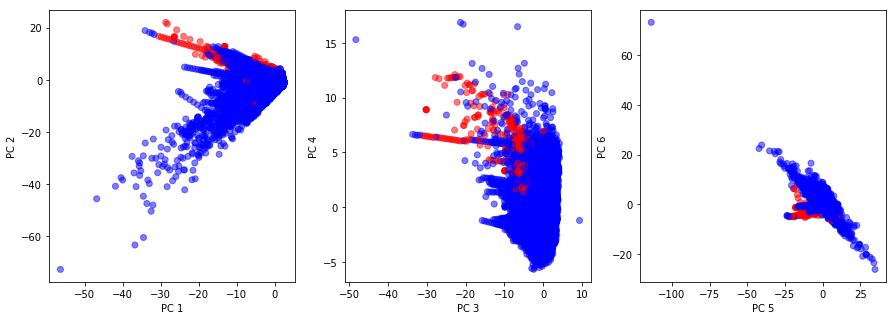

In [3]:
# View data on first six Principal Components
plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)
plt.scatter(raw_data.V1,raw_data.V2,c=raw_data.Class,alpha=.5, cmap='bwr')
ax2 = plt.subplot(132)
plt.scatter(raw_data.V3,raw_data.V4,c=raw_data.Class,alpha=.5, cmap='bwr')
ax3 = plt.subplot(133)
plt.scatter(raw_data.V5,raw_data.V6,c=raw_data.Class,alpha=.5, cmap='bwr')

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax2.set_xlabel('PC 3')
ax2.set_ylabel('PC 4')
ax3.set_xlabel('PC 5')
ax3.set_ylabel('PC 6');

Fraudulent credit card transactions cluster together in the first few principal components

In [4]:
# Format, scale, and split data
Y = raw_data['Class']
X_unscaled = raw_data.drop('Class', axis=1)
X = scale(X_unscaled)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 42)

### Undersample the majority non-fraudulent cases

In [5]:
# Undersample in the triaining set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, Y_train_resampled = rus.fit_sample(X_train, Y_train)

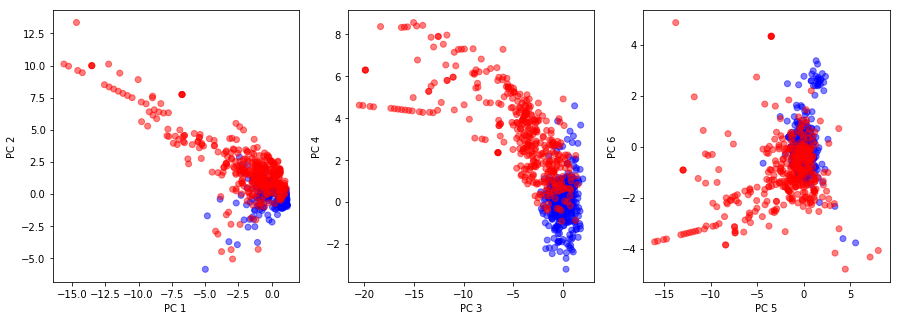

In [6]:
# Visualize resampled training data
plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)
plt.scatter(X_train_resampled[:,1], X_train_resampled[:,2], c=Y_train_resampled, alpha=.5, cmap='bwr')
ax2 = plt.subplot(132)
plt.scatter(X_train_resampled[:,3], X_train_resampled[:,4], c=Y_train_resampled, alpha=.5, cmap='bwr')
ax3 = plt.subplot(133)
plt.scatter(X_train_resampled[:,5], X_train_resampled[:,6], c=Y_train_resampled, alpha=.5, cmap='bwr')

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax2.set_xlabel('PC 3')
ax2.set_ylabel('PC 4')
ax3.set_xlabel('PC 5')
ax3.set_ylabel('PC 6');

### Linear SVM

In [7]:
# Linear SVC model
clf = LinearSVC()
clf.fit(X_train_resampled,Y_train_resampled)
Y_pred = clf.predict(X_test)
print classification_report(Y_test,Y_pred)
print roc_auc_score(Y_test,Y_pred)

             precision    recall  f1-score   support

          0       1.00      0.97      0.99     71089
          1       0.05      0.93      0.09       113

avg / total       1.00      0.97      0.98     71202

0.9501761907079708


In [8]:
# Tuning SVM parameters
parameter_grid = {'C': [1, 10, 100, 1000]}
grid_search = GridSearchCV(clf,param_grid = parameter_grid, verbose = 2, n_jobs = -1, scoring='roc_auc')
grid_search.fit(X_train_resampled, Y_train_resampled)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.966552004218
Best parameters: {'C': 1}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.6s finished


Linear SVM identifies 93% of fraudulent cases, with a caveat of only 5% precision (95% of charges detected as fraudulent would be legitimate)

### Kernel SVM

In [9]:
# Kernel SVM
clf = SVC()
clf.fit(X_train_resampled,Y_train_resampled)
Y_pred = clf.predict(X_test)
print classification_report(Y_test,Y_pred)
print roc_auc_score(Y_test,Y_pred)

             precision    recall  f1-score   support

          0       1.00      0.95      0.97     71089
          1       0.03      0.93      0.05       113

avg / total       1.00      0.95      0.97     71202

0.9378606425922285


In [10]:
# Tuning SVM parameters
parameter_grid = {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

grid_search = GridSearchCV(clf,param_grid = parameter_grid, verbose = 2, n_jobs = -1, scoring='roc_auc')
grid_search.fit(X_train_resampled, Y_train_resampled)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    3.5s


Best score: 0.980222129226
Best parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.7s finished


In [11]:
# Tuned Kernel SVM
clf = SVC(C=1, gamma=0.001,probability=True)
clf.fit(X_train_resampled,Y_train_resampled)
Y_pred = clf.predict(X_test)
print classification_report(Y_test,Y_pred)
print roc_auc_score(Y_test,Y_pred)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71089
          1       0.24      0.87      0.37       113

avg / total       1.00      1.00      1.00     71202

0.9313987190679713


Kernel SVM detects 87% of fraudulent transactions, and has much better precision (24%) compared to the Linear SVM model.